In [17]:
from splinter import Browser
from bs4 import BeautifulSoup

user input

In [40]:
item_name = input('What item are you looking for:' )
item_name = item_name.replace(" ", "+").lower()
item_name

'fire+rune'

scrape

In [41]:
executable_path = {"executable_path": "chromedriver"}
browser = Browser("chrome", **executable_path, headless=False)

In [42]:
url = f'http://www.itemdb.biz/index.php?search={item_name}'
browser.visit(url)


In [43]:
html = browser.html
soup = BeautifulSoup(html, 'html.parser')

table_row = soup.find_all('tbody')

for th in table_row:
    item_id = th.find('td').text
    item_name = th.find('td').next_element.next_element.next_element.next_element.next_element
    item_dict = {
        'item_name':item_name,
        'id': item_id
    }

In [44]:
browser.quit()

set up DFs

In [23]:
import requests
import json
import pandas as pd
import datetime

In [45]:
id = item_dict['id']
gen_url = f'https://secure.runescape.com/m=itemdb_rs/api/catalogue/detail.json?item={id}'
gen_response = requests.get(gen_url)

In [46]:
gen_json = gen_response.json()
gen_json

{'item': {'icon': 'https://secure.runescape.com/m=itemdb_rs/1595844083151_obj_sprite.gif?id=554',
  'icon_large': 'https://secure.runescape.com/m=itemdb_rs/1595844083151_obj_big.gif?id=554',
  'id': 554,
  'type': 'Runes, Spells and Teleports',
  'typeIcon': 'https://www.runescape.com/img/categories/Runes, Spells and Teleports',
  'name': 'Fire rune',
  'description': 'One of the four basic elemental runes. Used in Magic (13).',
  'current': {'trend': 'neutral', 'price': 134},
  'today': {'trend': 'neutral', 'price': 0},
  'members': 'false',
  'day30': {'trend': 'negative', 'change': '-14.0%'},
  'day90': {'trend': 'positive', 'change': '+36.0%'},
  'day180': {'trend': 'positive', 'change': '+65.0%'}}}

In [47]:
id = gen_json['item']['id']
name = gen_json['item']['name']
small_icon_url = gen_json['item']['icon']
large_icon_url = gen_json['item']['icon_large']
current_price = gen_json['item']['current']
short_delta = gen_json['item']['day30']
med_delta = gen_json['item']['day90']
long_delta = gen_json['item']['day180']

In [48]:
graph_url = f'http://services.runescape.com/m=itemdb_rs/api/graph/{id}.json'
graph_response = requests.get(graph_url)
graph_json = graph_response.json()

In [49]:
graph_daily = graph_json['daily']
graph_avg = graph_json['average']

In [ ]:
'''datetime.datetime.fromtimestamp(
    (1596153600000 / 1000)
).strftime('%m/%d/%Y')'''

In [50]:
gen_df = pd.DataFrame()
daily_graph_df = pd.DataFrame()
avg_graph_df = pd.DataFrame()

In [51]:
if type(current_price['price']) == int:
    gen_df['id'] = [id]
    gen_df['name'] = [name]
    gen_df['current_price'] = [current_price['price']]
    gen_df['_30_day_change'] = [short_delta['change'].strip('+%')]
    gen_df['_90_day_change'] = [med_delta['change'].strip('+%')]
    gen_df['_180_day_change'] = [long_delta['change'].strip('+%')]
else:
    gen_df['id'] = [id]
    gen_df['name'] = [name]
    gen_df['current_price'] = [current_price['price'].replace(',','')]
    gen_df['_30_day_change'] = [short_delta['change'].strip('+%')]
    gen_df['_90_day_change'] = [med_delta['change'].strip('+%')]
    gen_df['_180_day_change'] = [long_delta['change'].strip('+%')]

In [52]:
gen_df

,id,name,current_price,_30_day_change,_90_day_change,_180_day_change
0,554,Fire rune,134,-14.0,36.0,65.0


In [53]:
daily_keys = graph_daily.keys()
daily_values = graph_daily.values()
correct_daily_keys = []
correct_daily_value = []
daily_values

dict_values([80, 79, 79, 78, 78, 79, 79, 80, 81, 81, 81, 81, 80, 79, 79, 79, 78, 78, 77, 76, 75, 74, 75, 76, 76, 76, 75, 75, 76, 78, 78, 77, 77, 76, 77, 77, 77, 77, 79, 79, 80, 79, 79, 79, 79, 80, 82, 84, 84, 83, 83, 84, 86, 87, 89, 92, 93, 91, 89, 88, 86, 85, 84, 83, 82, 82, 82, 81, 81, 81, 83, 85, 85, 85, 83, 84, 85, 85, 86, 88, 90, 91, 93, 94, 95, 94, 96, 97, 97, 98, 98, 97, 95, 94, 94, 95, 96, 97, 98, 100, 100, 102, 102, 104, 107, 110, 114, 117, 117, 119, 120, 120, 121, 126, 132, 136, 139, 138, 141, 143, 143, 144, 145, 148, 152, 155, 159, 162, 166, 168, 167, 166, 166, 167, 165, 162, 160, 159, 159, 159, 161, 163, 164, 168, 170, 165, 162, 159, 157, 157, 157, 156, 155, 156, 154, 152, 148, 145, 142, 139, 137, 135, 134, 132, 131, 128, 126, 125, 123, 121, 120, 119, 117, 118, 121, 124, 127, 131, 134, 134])

In [54]:
for key in daily_keys:
    timestamp = datetime.datetime.fromtimestamp(( int(key) / 1000)).strftime('%m/%d/%Y')
    correct_daily_keys.append(timestamp)

for value in daily_values:
    correct_daily_value.append(value)

In [71]:
daily_graph_df['Date'] = correct_daily_keys
daily_graph_df['price'] = correct_daily_value

In [72]:
daily_graph_df

,Date,price
0,02/02/2020,80
1,02/03/2020,79
2,02/04/2020,79
3,02/05/2020,78
4,02/06/2020,78
...,...,...
175,07/26/2020,124
176,07/27/2020,127
177,07/28/2020,131
178,07/29/2020,134


connect sql server

In [35]:
from sqlalchemy import create_engine

In [55]:
connection_string = 'postgres:nwyfre@localhost:5432/osrs_ge_tracker_db'
engine = create_engine(f'postgresql://{connection_string}')

In [73]:
# Confirm tables
gen_df.to_sql(name='temp_holding', con=engine, if_exists='replace', index=False)
daily_graph_df.to_sql(name='price_over_time', con=engine, if_exists='replace', index=False)
conn = engine.connect()
trans = conn.begin()

In [74]:
try:
    engine.execute('delete from general_info where id in(select id from temp_holding)')
    
    gen_df.to_sql(name='general_info', con=engine, if_exists='append', index=False)

except:
    trans.rollback()
    raise

create graph

In [103]:
import matplotlib.pyplot as plt

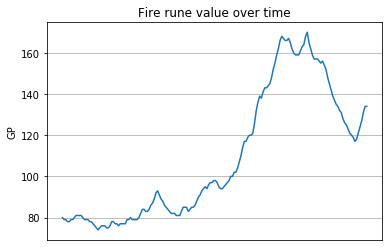

In [104]:
plt.plot(daily_graph_df['Date'], daily_graph_df['price'])
plt.title(f'{name} value over time')
plt.ylabel('GP')
axes = plt.gca()
axes.yaxis.grid()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show
plt.savefig('img/valueovertime.png')